# Loading Libraries

In [1]:
import os
import shutil
import random
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from collections import Counter
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import PIL
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, fbeta_score

colors = ['#648E9C', '#9CB1BC', '#C5D4DE', '#E8F1F4']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
plt.style.use('seaborn-darkgrid')

In [ ]:
device

# Functions

## Visualization

In [ ]:
# Function to plot samples
def plot_samples(images, N=5):
    ps = random.sample(range(0, images.shape[0]), N**2)
    f, axarr = plt.subplots(N, N, figsize=(10, 10))
    p = 0
    for i in range(N):
        for j in range(N):
            im = images[ps[p]].transpose(1, 2, 0)
            im = im / 2 + 0.5  # Unnormalize the image
            axarr[i, j].imshow(im)
            axarr[i, j].axis('off')
            p += 1
    plt.show()

In [17]:
def display_filters(weights, filename):
    N = int(np.ceil(np.sqrt(weights.shape[0])))
    f, axarr = plt.subplots(N, N, figsize=(12, 12))
    scaled = (weights - weights.min()) / (weights.max() - weights.min())  # Scale the weights for better plotting

    p = 0
    for i in range(N):
        for j in range(N):
            # Empty plot white when out of kernels to display
            if p >= scaled.shape[0]:
                krnl = torch.ones((scaled.shape[2], scaled.shape[3], 3))
            else:
                if scaled.shape[1] == 1:
                    krnl = scaled[p, :, :, :].permute(1, 2, 0)
                    axarr[i, j].imshow(krnl, cmap="gray")
                elif scaled.shape[1] == 3:
                    krnl = scaled[p, :, :, :].permute(1, 2, 0)
                    axarr[i, j].imshow(krnl)
                else:
                    krnl = scaled[p, 0, :, :]
                    axarr[i, j].imshow(krnl, cmap="gray")
            axarr[i, j].axis("off")
            p += 1

    # Save the figure
    plt.savefig(filename)

    # Show the plot
    plt.show()

In [16]:
def get_conv_layers(network):
    conv_layers = []
    conv_layers_names = []
    for name, module in network.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append(module)
            conv_layers_names.append(name)
    return conv_layers, conv_layers_names

In [15]:
def visualize_conv_filters(model, model_folder, dt_str):
    conv_result_folder = os.path.join(model_folder, f'conv_layers_{dt_str}')
    os.makedirs(conv_result_folder, exist_ok=True)
    conv_layers, _ = get_conv_layers(model)

    # Now you can proceed with your existing code
    for i, conv_layer in enumerate(conv_layers):
        print(f"Filters of Conv Layer {i+1}:")
        filters = conv_layer.weight.data.clone().cpu()
        filename = os.path.join(conv_result_folder, f"conv_layer_{i+1}_filters.png")  # Filename for saving the figure
        display_filters(filters, filename)

In [ ]:
# Visualization function with unnormalization and saving the figure
def vis_topk(ims, units, filename="top_k_activations.png"):
    f, axarr = plt.subplots(ims.shape[0], ims.shape[1], figsize=(16, 12))

    for i in range(ims.shape[0]):
        for j in range(ims.shape[1]):
            axarr[i, j].imshow(ims[i, j, :, :, :])
            axarr[i, j].axis('off')
            if i == 0:  # Only set the title for the top row
                axarr[i, j].set_title('Unit ' + str(units[j]))

    # Adjust layout
    plt.tight_layout()
    # Save the figure
    plt.savefig(filename)
    # Show the plot
    plt.show()

#### t-SNE plot on each of the Dense/Linear/Fully Connected layer.

In [2]:
def plot_tsne(activations_tsne, labels, title='t-SNE visualization', figsize=(12, 10), point_size=20, cmap='tab10', filename='dense_layer_tsne.png'):
    num_classes = len(np.unique(labels))
    cifar_labels = [str(i) for i in range(num_classes)]
    
    plt.figure(figsize=figsize)
    scatter = plt.scatter(activations_tsne[:, 0], activations_tsne[:, 1], c=labels, cmap=plt.get_cmap(cmap, num_classes), s=point_size, alpha=0.6)
    plt.clim(-0.5, num_classes - 0.5)
    cbar = plt.colorbar(scatter, ticks=range(num_classes))
    cbar.ax.set_yticklabels(cifar_labels)
    plt.title(title)
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.grid(True)

    # Save the figure
    plt.savefig(filename)
    
    # Show the plot
    plt.show()

## Train and Test

In [ ]:
def correct_predictions(predicted_batch, label_batch):
    pred = predicted_batch.argmax(dim=1, keepdim=True)
    return pred.eq(label_batch.view_as(pred)).sum().item()

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

def train_epoch(epoch, train_loader, network, optimizer, criterion, hparams, file_path):
    network.train()
    device = hparams['device']
    network.to(device)
    avg_loss = 0
    with open(file_path, 'a') as file:
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = network(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if batch_idx % hparams['log_interval'] == 0:
                log_str = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                           f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}\n')
                file.write(log_str)
                print(log_str, end='')  # print without adding an extra new line
    return avg_loss / len(train_loader)

def validation_epoch(validation_loader, network, hparams, file_path):
    network.eval()
    device = hparams['device']
    validation_loss = 0
    correct = 0
    with torch.no_grad(), open(file_path, 'a') as file:
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            validation_loss += F.cross_entropy(output, target, reduction='sum').item()
            correct += correct_predictions(output, target)
        validation_loss /= len(validation_loader.dataset)
        test_acc = 100. * correct / len(validation_loader.dataset)
        log_str = (f'\nValidation set: Average loss: {validation_loss:.4f}, Accuracy: {correct}/{len(validation_loader.dataset)} '
                   f'({test_acc:.0f}%)\n')
        file.write(log_str)
        print(log_str, end='')  # print without adding an extra new line
    return validation_loss, test_acc

## Plotting Results, Training and Testing Losses

In [ ]:
def plot_and_save_results(tr_losses, val_losses, val_accs, filepath):
    plt.figure(figsize=(14, 6))

    # Training and Testing Losses
    plt.subplot(1, 2, 1)
    plt.plot(tr_losses, label='Training Loss', color='#1f77b4', linewidth=2, marker='o')
    plt.plot(val_losses, label='Validation Loss', color='#ff7f0e', linewidth=2, marker='x')
    plt.title('Training and Validation Loss Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Testing Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accs, label='Validation Accuracy', color='green', linewidth=2, marker='^')
    plt.title('Validation Accuracy Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.savefig(filepath, dpi=300)
    plt.show()

In [ ]:
def display_results(y_true, y_preds, class_labels):
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds)).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)

    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")
    return results, conf_mat

def plot_confusion_matrix(conf_mat, filepath):
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap=sns.color_palette("icefire", as_cmap=True), xticklabels=conf_mat.columns, yticklabels=conf_mat.index)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(filepath, dpi=300)
    plt.show()

In [ ]:
def plot_predictions(images, y_true, y_preds, class_indices, filepath, num_samples=20):
    
    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(len(images), size=num_samples, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        # Convert from PyTorch format (C, H, W) to image format (H, W, C)
        ax.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
        
        # Set title with predicted and true labels
        ax.set_title(f"{class_indices[pred_idx]}\n(True: {class_indices[true_idx]})", 
                     color=("green" if pred_idx == true_idx else "red"))
    
    plt.tight_layout()
    plt.savefig(filepath, dpi=300)
    plt.show()

## Setting-up Hyperparameters

In [3]:
# from https://arxiv.org/pdf/1512.03385.pdf
hparams = {
    'batch_size': 512,
    'num_epochs': 100,
    'learning_rate':  0.001,
    'learning_rate_factor': 0.1,
    'weight_decay': 0.0001,
    'log_interval': 10,
    'device': device,
    'num_classes': 10
}


## Brief Overview of the Data

In [4]:
DATASET = "./data/EuroSAT_RGB"

LABELS = os.listdir(DATASET)
print(LABELS)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center', color= colors[1])
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=90)
plt.xlabel('Class Label', fontsize=13)
plt.ylabel('Class Size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [ ]:
print(f'Dataset Size: {sum(counts.values())}')

The dataset is split into 10 classes of land cover. Each class varies in size, so I'll have to stratify later on when splitting the data into training, testing and validation sets.

In [ ]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

Upon reviewing the various class previews, we observe certain commonalities and distinct contrasts among them.

Classes depicting urban settings like `Highways`, `Residential` areas, and `Industrial` sites predominantly feature man-made structures and roadways.

Both `AnnualCrops` and `PermanentCrops` classes display agricultural areas, characterized by straight lines marking different crop fields.

In contrast, classes such as `HerbaceousVegetation`, `Pasture`, and `Forests` represent natural landscapes. `Rivers`, also a part of the natural landscape category, are somewhat more distinguishable from these other natural classes.

Analyzing the imagery content might give insights into potential class confusions. For instance, a `River` image could be misidentified as a `Highway`. Similarly, an image showing a highway junction with nearby buildings might be confused for an `Industrial` area. To overcome these challenges, it's crucial to develop a classifier that can adeptly discern these subtle differences.

Regarding Sentinel-2 satellite imagery, it's possible to access over 10 additional spectral bands. For instance, the `Near-Infrared Radiation (NIR)` band is available in this dataset and can be utilized to create indices that visualize the presence or absence of radiation in an image. However, this dataset lacks NIR wavelength bands, rendering this approach infeasible for our current analysis. Nonetheless, it's important to note that NIR data could offer an alternative method for tackling this classification task.

# Dataset

## Creating Train, Validation and Test Directories

In [5]:
TRAIN_DIR = './data/train'
VALID_DIR = './data/valid'
TEST_DIR = './data/test'

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VALID_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# And open_project folder
os.makedirs(f'../open_project/', exist_ok=True)

# create class label subdirectories in train and test
for l in LABELS:
    os.makedirs(os.path.join(TRAIN_DIR, l), exist_ok=True)
    os.makedirs(os.path.join(VALID_DIR, l), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, l), exist_ok=True)

## Splitting Data to Train and Test

### Uncomment Code Below when Run for First Time

In [ ]:
# # Creating a dictionary with image paths and labels
# data = {os.path.join(DATASET, l, img): l for l in LABELS for img in os.listdir(os.path.join(DATASET, l))}

# X = pd.Series(list(data.keys()))
# y = pd.get_dummies(pd.Series(data.values()))

# # First split: Splitting into training and temporary set (combining test and validation)
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=69)  # 30% for test + validation

# for train_idx, temp_idx in split.split(X, y):
#     train_paths = X[train_idx].tolist()
#     temp_paths = X[temp_idx].tolist()

# # Second split: Splitting the temporary set into test and validation
# split_temp = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=69)  # 50% of 30% -> 15% each for test and validation
# y_temp = y.iloc[temp_idx]

# for test_idx, val_idx in split_temp.split(pd.Series(temp_paths), y_temp):
#     test_paths = pd.Series(temp_paths).iloc[test_idx].tolist()
#     val_paths = pd.Series(temp_paths).iloc[val_idx].tolist()

# # Define new paths without using regex
# new_train_paths = [path.replace(DATASET, TRAIN_DIR) for path in train_paths]
# new_test_paths = [path.replace(DATASET, TEST_DIR) for path in test_paths]
# new_val_paths = [path.replace(DATASET, VALID_DIR) for path in val_paths]

# train_path_map = zip(train_paths, new_train_paths)
# test_path_map = zip(test_paths, new_test_paths)
# val_path_map = zip(val_paths, new_val_paths)

In [ ]:
# Move the files
# print("Moving training files..")
# for old_path, new_path in tqdm(train_path_map):
#     os.makedirs(os.path.dirname(new_path), exist_ok=True)
#     shutil.copy(old_path, new_path)

# print("Moving testing files..")
# for old_path, new_path in tqdm(test_path_map):
#     os.makedirs(os.path.dirname(new_path), exist_ok=True)
#     shutil.copy(old_path, new_path)

# print("Moving validation files..")
# for old_path, new_path in tqdm(val_path_map):
#     os.makedirs(os.path.dirname(new_path), exist_ok=True)
#     shutil.copy(old_path, new_path)

## Loading and Preprocessing Train, Validation and Test Sets

In [6]:
# Define transformations for training
mean = [0.485, 0.456, 0.406] # Adjust as needed
std = [0.229, 0.224, 0.225] # Adjust as needed

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(60),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # BETTER RESULTS WITHOUT THIS
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  
])

# Define transformations for testing (only normalization)
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  
])

# Create the dataset and dataloader for training
# Comparison of models with 15 epochs was completed only with train_dataset (size of 18900 with train_transforms)
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
# train_dataset_augmented = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
# train_dataset = ConcatDataset([train_dataset_original, train_dataset_augmented])
train_loader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)

# Optionally create the dataset and dataloader for validation
valid_dataset = datasets.ImageFolder(root=VALID_DIR, transform=test_transforms)
valid_loader = DataLoader(valid_dataset, batch_size=hparams['batch_size'], shuffle=False)

# Create the dataset and dataloader for testing
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False)

In [ ]:
print(f'Train Dataset Size: {len(train_dataset)}')
print(f'Validation Dataset Size: {len(valid_dataset)}')
print(f'Test Dataset Size: {len(test_dataset)}')

In [ ]:
# Function to count instances per label in a dataset
def count_labels(dataset):
    label_counts = Counter()
    for _, label in dataset:
        label_counts[label] += 1
    return label_counts

# Count labels in each dataset
train_label_counts = count_labels(train_dataset)
valid_label_counts = count_labels(valid_dataset)
test_label_counts = count_labels(test_dataset)

In [ ]:
# Function to plot the counts
def plot_label_distribution(counts, title, color):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(counts)), list(counts.values()), align='center', color=color)
    plt.xticks(range(len(counts)), LABELS, fontsize=12, rotation=90)
    plt.xlabel('Class Label', fontsize=13)
    plt.ylabel('Class Size', fontsize=13)
    plt.title(title, fontsize=15)
    plt.show()

In [ ]:
# Plot the distributions
plot_label_distribution(train_label_counts, 'EUROSAT Train Class Distribution', colors[1])
plot_label_distribution(valid_label_counts, 'EUROSAT Validation Class Distribution', colors[1])
plot_label_distribution(test_label_counts, 'EUROSAT Test Class Distribution', colors[1])

In [ ]:
# Get Class indices dictionary
class_indices = train_dataset.class_to_idx
# Reverse the mapping to get indices to class names
idx_to_class = {v: k for k, v in class_indices.items()}
print(class_indices)
print(idx_to_class)

In [ ]:
train_dataset[0][0].shape

## Visualize the Preprocessed Data

In [ ]:
# Fetch the first batch of images from the trainloader
first_batch_images, _ = next(iter(train_loader))
first_image = first_batch_images[0].unsqueeze(0).to(hparams['device'])

In [ ]:
first_batch_images_np = first_batch_images.numpy()

# Plot samples from the first batch
plot_samples(first_batch_images_np)

# Model Instantiation

## EUROSatCNN

In [ ]:
class EUROSatCNN(nn.Module):
    def __init__(self, num_classes):
        super(EUROSatCNN, self).__init__()
        self.num_classes = num_classes

        # First set of convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        # Second set of convolutional layers
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(2, 2) 
        self.dropout2 = nn.Dropout(0.25)

        # Third set of convolutional layers
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.LeakyReLU()
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(2, 2)  # output size: 8x8
        self.dropout3 = nn.Dropout(0.25)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 128)  # 8x8 is the size after pooling layers
        self.relu7 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, self.num_classes)  # Assuming 10 classes
    
    def forward(self, x):
        # First set of layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second set of layers
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third set of layers
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten the output
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

## Function Instatiating Specific Model

In [ ]:
def compile_model(cnn_base, num_classes, file_path):
    # Choose the base model and modify the classifier
    if cnn_base in ['ResNet50', 'ResNet152']:
        if cnn_base == 'ResNet50':
            model = models.resnet50(pretrained=True)
            # Freeze the parameters
            for param in model.parameters():
                param.requires_grad = False
            # Replace the final fully connected layer
            # Extend the classifier
            num_ftrs = model.fc.in_features
        elif cnn_base == 'ResNet152':
            model = models.resnet152(pretrained=True)
            # Freeze the parameters
            for param in model.parameters():
                param.requires_grad = False
            # Replace the final fully connected layer
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes)
        else:
            raise ValueError("Unsupported ResNet model base")
    
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes)
        )
    
    elif cnn_base in ['VGG16', 'VGG19']:
        if cnn_base == 'VGG16':
            model = models.vgg16(pretrained=True)
            # Freeze the parameters
            for param in model.parameters():
                param.requires_grad = False
        
        elif cnn_base == 'VGG19':
            model = models.vgg19(pretrained=True)
            # Freeze the parameters
            for param in model.parameters():
                param.requires_grad = False
        else:
            raise ValueError("Unsupported VGG model base")
        
        # Modify and extend the classifier
        model.classifier = nn.Sequential(
            nn.Linear(25088, 2048),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1024, num_classes)
        )

    elif cnn_base == "EUROSatCNN":
        model = EUROSatCNN(num_classes)
    else:
        raise ValueError("Unsupported Model")
    
    # Get the current datetime
    dt = datetime.now()

    # Format the datetime as a string in the specified format: year_month_day_hour_minute
    str_dt = dt.strftime("%Y_%m_%d_%H_%M")
    
    file_path = os.path.join(file_path, f'architecture_{str_dt}.txt')
    
    total_params, trainable_params, non_trainable_params = count_parameters(model)
    
    with open(file_path, 'a') as file:
        file.write('-------------------------------------------------------------------\n')
        file.write(f'{(model)}\n')
        file.write('-------------------------------------------------------------------\n')
        file.write(f'Total parameters in the model: {total_params}\n')
        file.write(f'Trainable parameters in the model: {trainable_params}\n')
        file.write(f'NON-Trainable parameters in the model: {non_trainable_params}\n')
        file.write('-------------------------------------------------------------------\n')
        file.write('-------------------------------------------------------------------\n')
        file.write(str(hparams))
        
    
    print('-------------------------------------------------------------------\n')
    print(f'{(model)}\n')
    print('-------------------------------------------------------------------\n')
    print(f'Total parameters in the model: {total_params}\n')
    print(f'Trainable parameters in the model: {trainable_params}\n')
    print(f'NON-Trainable parameters in the model: {non_trainable_params}\n')
    print('-------------------------------------------------------------------\n')

    return model, str_dt

# Training Process

In [ ]:
def training_process(network, nework_name, model_folder, str_dt):
    
    train_log_path = os.path.join(model_folder, f'training_log_{str_dt}.txt')
    losses_figure_path = os.path.join(model_folder, f'losses_{str_dt}_.png')
    
    # Initialize variables for Early Stopping and Model Checkpoint
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    patience = 15  # For early stopping
    

    # Define the optimizer with or without L2 regularization
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, network.parameters()), lr=hparams['learning_rate'], weight_decay=hparams['weight_decay'])

    # Define the criterion
    criterion = nn.CrossEntropyLoss()

    # Initialize ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=hparams['learning_rate_factor'], patience=3, min_lr=0.001)

    early_stopping_triggered = False


    # Training and validation loop
    tr_losses, val_losses, val_accs = [], [], []

    # Start the timer
    start_time = time.time()

    for epoch in range(1, hparams['num_epochs'] + 1):
        train_loss = train_epoch(epoch, train_loader, network, optimizer, criterion, hparams, train_log_path)
        tr_losses.append(train_loss)
        val_loss, val_acc = validation_epoch(valid_loader, network, hparams, train_log_path)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    

        # Model Checkpoint
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            model_path = os.path.join(model_folder, f'best_model_{str_dt}.pth')
            torch.save(network.state_dict(), model_path)
            with open(train_log_path, 'a') as file:
                file.write(f"Checkpoint saved at {model_path} \n")
            print(f"Checkpoint saved at {model_path} \n")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early Stopping
        if epochs_no_improve == patience:
            with open(train_log_path, 'a') as file:
                file.write("Early stopping triggered. Exiting training loop. \n")
            print("Early stopping triggered. Exiting training loop. \n")
            early_stopping_triggered = True
            break

        # Learning Rate Scheduler Step
        scheduler.step(val_acc)

    if not early_stopping_triggered:
        with open(train_log_path, 'a') as file:
            file.write("Completed training for {} epochs \n".format(hparams['num_epochs']))
        print("Completed training for {} epochs \n".format(hparams['num_epochs']))
    
    # Stop the timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Convert elapsed time to minutes and seconds
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)

    with open(train_log_path, 'a') as file:
        file.write(f'Total Training Time: {elapsed_mins}m {elapsed_secs}s \n')
    print(f'Total Training Time: {elapsed_mins}m {elapsed_secs}s \n')
    
    plot_and_save_results(tr_losses, val_losses, val_accs, losses_figure_path)
    
    return tr_losses, val_losses, val_accs, nework_name

# Models

Uncomment the respective `Model` which you want to train and test!

## ResNet50

In [ ]:
# model_folder = '../open_project/ResNet50'
# os.makedirs(model_folder, exist_ok=True)
# ResNet50_model, str_dt = compile_model('ResNet50', hparams['num_classes'], model_folder)

In [ ]:
# tr_losses, val_losses, val_accs, network_name = training_process(ResNet50_model, "ResNet50", model_folder, str_dt)

In [ ]:
# model = ResNet50_model

## ResNet152

In [ ]:
# model_folder = '../open_project/ResNet152'
# os.makedirs(model_folder, exist_ok=True)
# ResNet152_model, str_dt = compile_model('ResNet152', hparams['num_classes'], model_folder)

In [ ]:
# tr_losses, val_losses, val_accs, network_name = training_process(ResNet152_model, "ResNet152", model_folder, str_dt)

In [ ]:
# model = ResNet152_model

## VGG16

In [ ]:
# FINAL 2 IS WITHOUT THE ONE PREPROCESSING STEP OF THE AUGMENTATION
# FINAL 3 IS THE SAME AS FINAL 2 BUT WITH PATIENCE = 15 FOR EARLY STOPPING
# model_folder = '../open_project/VGG16_final3'
# os.makedirs(model_folder, exist_ok=True)
# VGG16_model, str_dt = compile_model('VGG16', hparams['num_classes'], model_folder)

In [ ]:
# tr_losses, val_losses, val_accs, network_name = training_process(VGG16_model, "VGG16", model_folder, str_dt)

In [ ]:
# model = VGG16_model

## VGG19

In [ ]:
# model_folder = '../open_project/VGG19'
# os.makedirs(model_folder, exist_ok=True)
# VGG19_model, str_dt = compile_model('VGG19', hparams['num_classes'], model_folder)

In [ ]:
# tr_losses, val_losses, val_accs, network_name = training_process(VGG19_model, "VGG19", model_folder, str_dt)

In [ ]:
# model = VGG19_model

## EUROSatCNN

In [ ]:
# model_folder = '../open_project/EUROSatCNN'
# os.makedirs(model_folder, exist_ok=True)
# EUROSatCNN, str_dt = compile_model('EUROSatCNN', hparams['num_classes'], model_folder)

In [ ]:
# tr_losses, val_losses, val_accs, nework_name = training_process(EUROSatCNN, "EUROSatCNN", model_folder, str_dt)

In [ ]:
# model = EUROSatCNN

# Loading Model for Testing

The following chunk can be used in case you want to load a specific model and check its `predictability power`!

In [7]:
# EUROSatCNN
# model = EUROSatCNN(hparams['num_classes'])
# model_folder = '../open_project/EUROSatCNN_no_fine_tune'
# model_version = "best_model_2024_01_09_00_49.pth"


# ResNet152 & 50
# model_folder = '../open_project/ResNet152'
# model_folder = '../open_project/ResNet50'
# model_version = "best_model_2024_01_11_15_14.pth"

# model = models.resnet152(pretrained=True)
# model = models.resnet50(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, hparams['num_classes'])
# model.fc = nn.Sequential(
#             nn.Linear(num_ftrs, 1024),
#             nn.ReLU(),
#             nn.Dropout(0.25),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Dropout(0.25),
#             nn.Linear(512, hparams['num_classes'])
#         )


# VGG16 & VGG19
model_folder = '../open_project/VGG16_final3'
# model_folder = '../open_project/VGG19'
model_version = "best_model_2024_01_11_22_13.pth"
# model_version = "best_model_2024_01_11_17_09.pth"

model = models.vgg16(pretrained=True)
# model = models.vgg19(pretrained=True)
# # Freeze the parameters
for param in model.parameters():
    param.requires_grad = False
# Modify and extend the classifier
model.classifier = nn.Sequential(
    nn.Linear(25088, 2048),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(1024, hparams['num_classes'])
)


# Extracting the date and time part using string slicing
str_dt = model_version[len("best_model_"):-len(".pth")]
model_path = os.path.join(model_folder, model_version)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Model Evaluation

## Train Predictions

In [ ]:
# Load a batch of images and their labels from the test_loader
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

# Predict labels
model.eval()
model.to(device)
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

In [ ]:
# Map predicted and true labels back to class names
predicted_labels = [idx_to_class[idx] for idx in predicted.cpu().numpy()]
true_labels = [idx_to_class[idx] for idx in labels.cpu().numpy()]

filename = os.path.join(model_folder, f'plot_train_predictions_{str_dt}.png')

# Visualize predictions
plot_predictions(images, true_labels, predicted_labels, class_indices, filename)

In [ ]:
# Initialize lists to store true and predicted labels
all_labels = []
all_predictions = []

# Predict labels for the entire test dataset
model.eval()
model.to(device)
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to the lists
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

In [ ]:
# Now you can pass all_labels and all_predictions to the display_results function
prf, conf_mat = display_results(all_labels, all_predictions, class_indices)


filename = os.path.join(model_folder, f'prf_train_{str_dt}.csv')

# Save the DataFrame to a CSV file
prf.to_csv(filename, index=False)

In [ ]:
prf

In [ ]:
conf_mat

In [ ]:
# Use the function to plot the confusion matrix
filename = os.path.join(model_folder, f'train_cm_{str_dt}.png')
plot_confusion_matrix(conf_mat, filename)

## Test Predictions

In [ ]:
# Load a batch of images and their labels from the test_loader
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Predict labels
model.eval()
model.to(device)
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

In [ ]:
# Map predicted and true labels back to class names
predicted_labels = [idx_to_class[idx] for idx in predicted.cpu().numpy()]
true_labels = [idx_to_class[idx] for idx in labels.cpu().numpy()]

filename = os.path.join(model_folder, f'plot_test_predictions_{str_dt}.png')

# Visualize predictions
plot_predictions(images, true_labels, predicted_labels, class_indices, filename)

In [ ]:
# Initialize lists to store true and predicted labels
all_labels = []
all_predictions = []

# Predict labels for the entire test dataset
model.eval()
model.to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to the lists
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

In [ ]:
# Now you can pass all_labels and all_predictions to the display_results function
prf, conf_mat = display_results(all_labels, all_predictions, class_indices)


filename = os.path.join(model_folder, f'prf_test_{str_dt}.csv')

# Save the DataFrame to a CSV file
prf.to_csv(filename, index=False)

In [ ]:
prf

In [ ]:
conf_mat

In [ ]:
# Use the function to plot the confusion matrix
filename = os.path.join(model_folder, f'test_cm_{str_dt}.png')
plot_confusion_matrix(conf_mat, filename)

# Model Interpretability

## Filters (Convolutions)

Filters of Conv Layer 1:


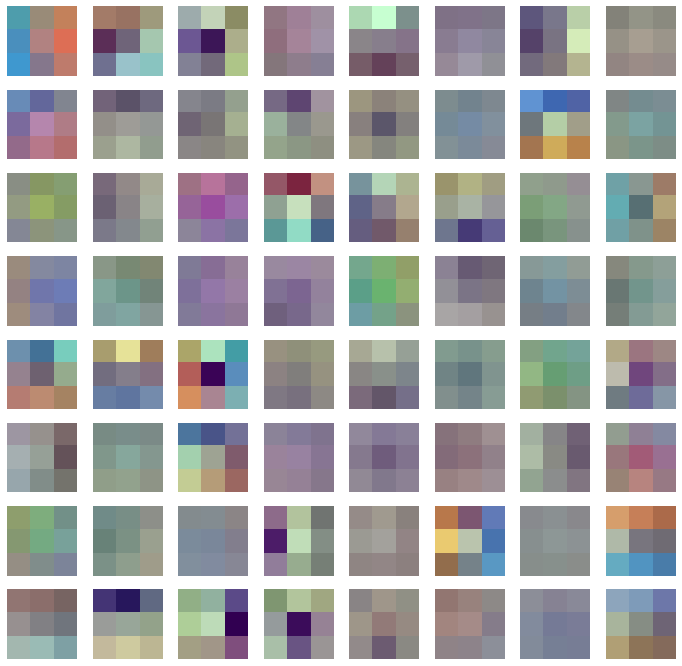

Filters of Conv Layer 2:


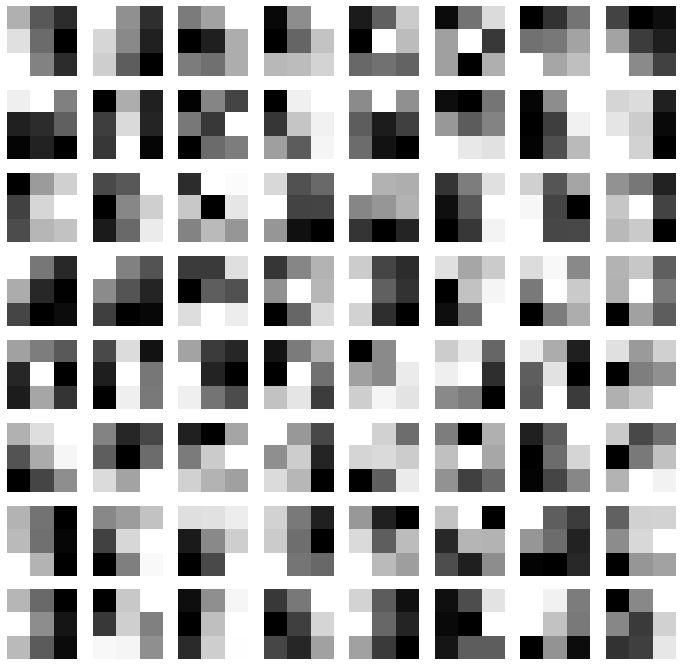

Filters of Conv Layer 3:


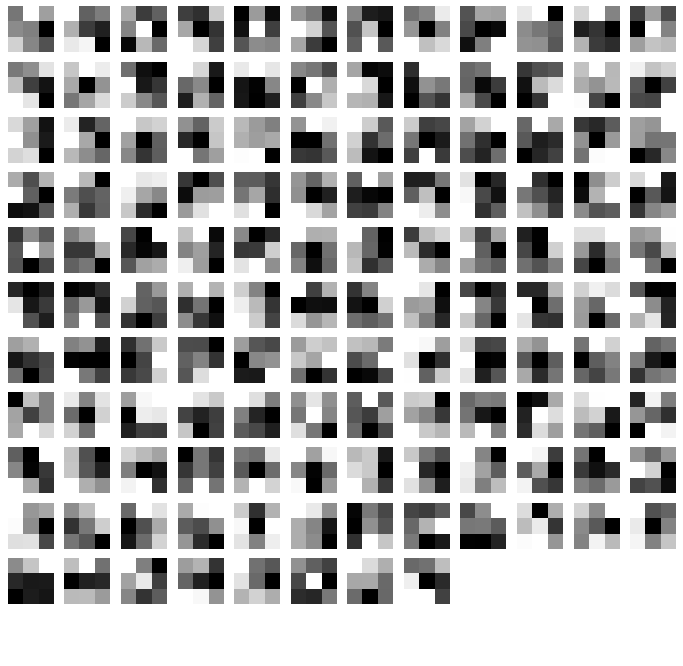

Filters of Conv Layer 4:


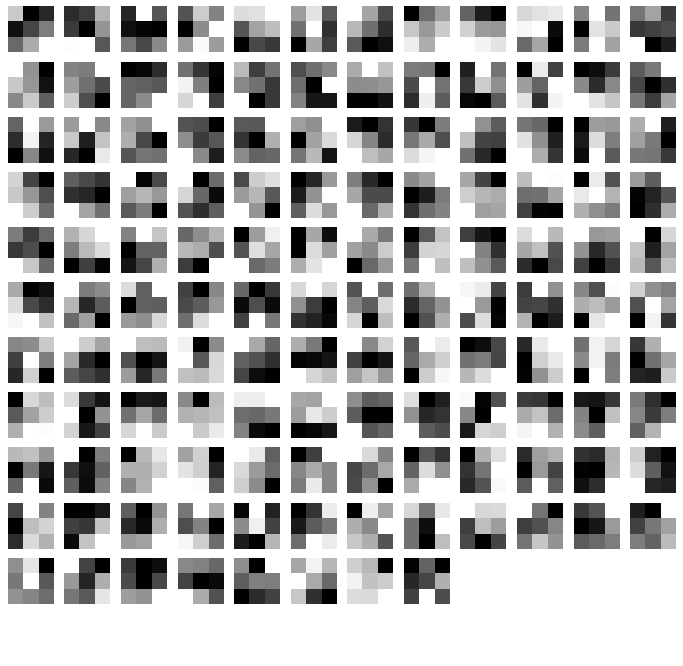

Filters of Conv Layer 5:


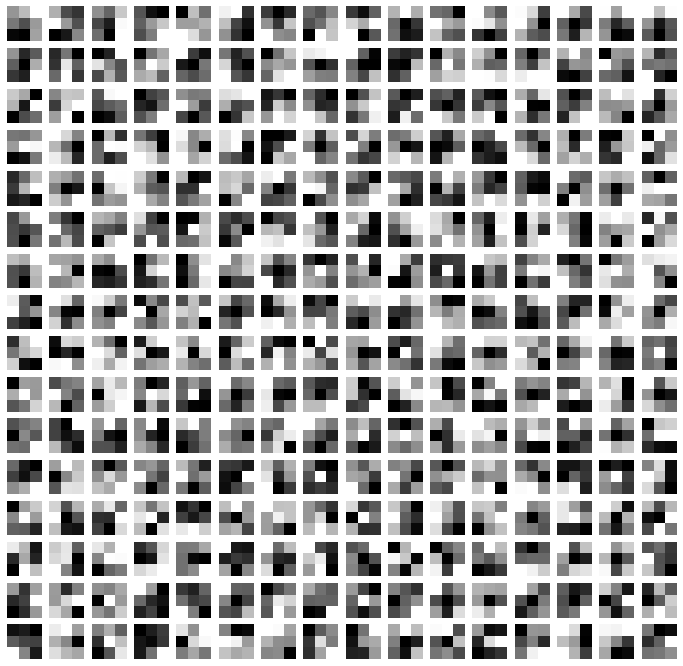

Filters of Conv Layer 6:


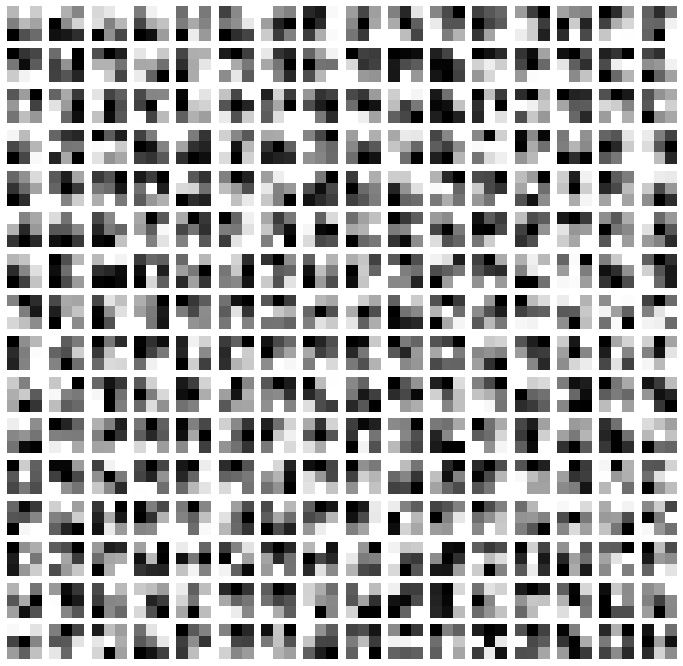

Filters of Conv Layer 7:


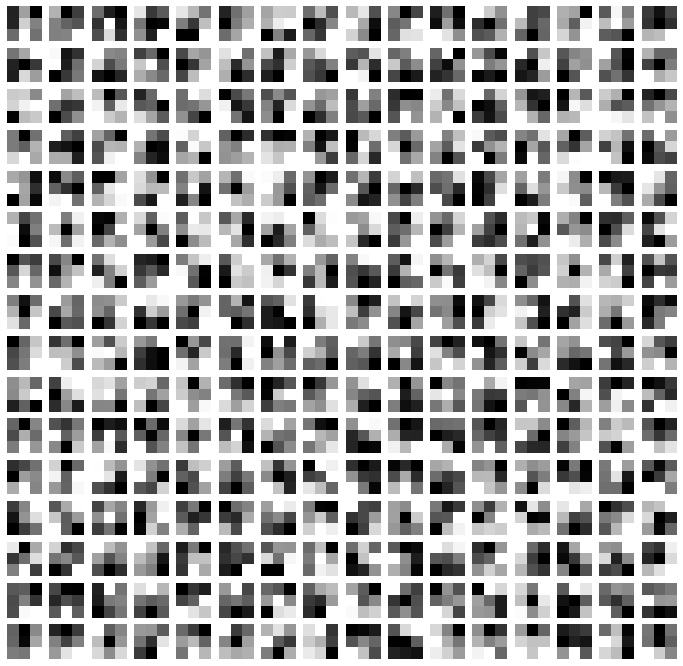

Filters of Conv Layer 8:


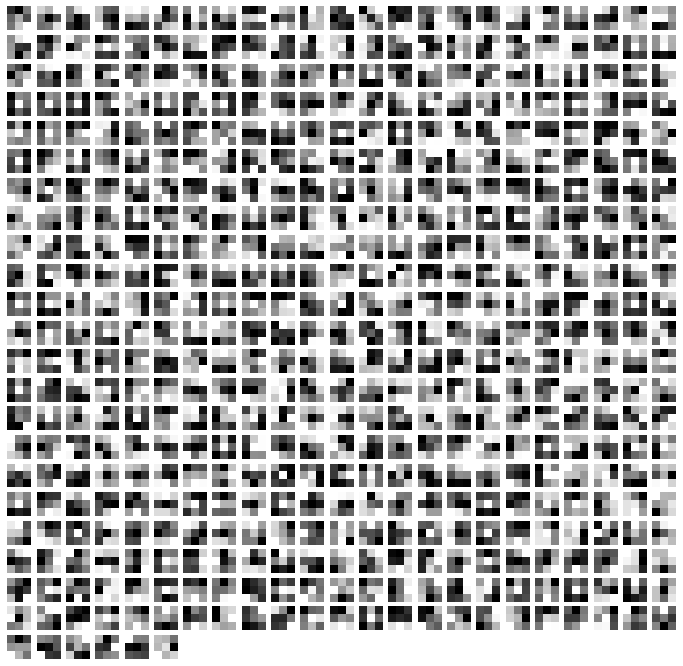

Filters of Conv Layer 9:


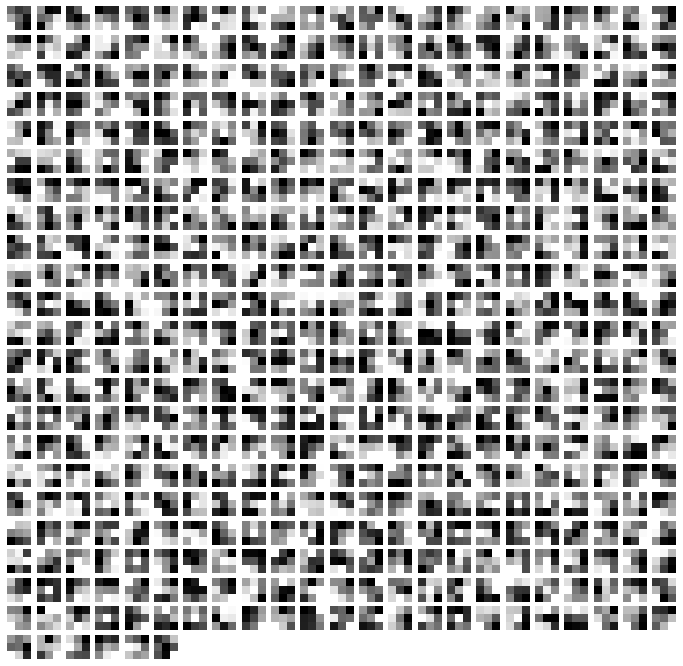

Filters of Conv Layer 10:


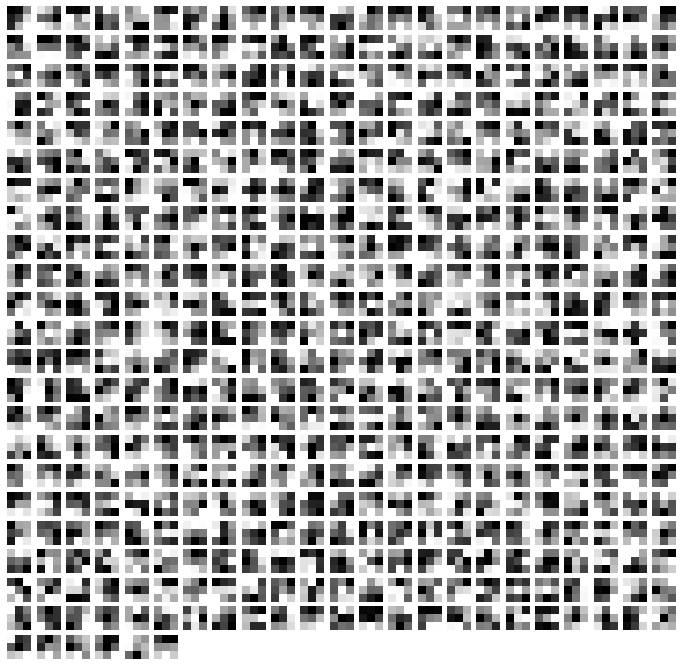

Filters of Conv Layer 11:


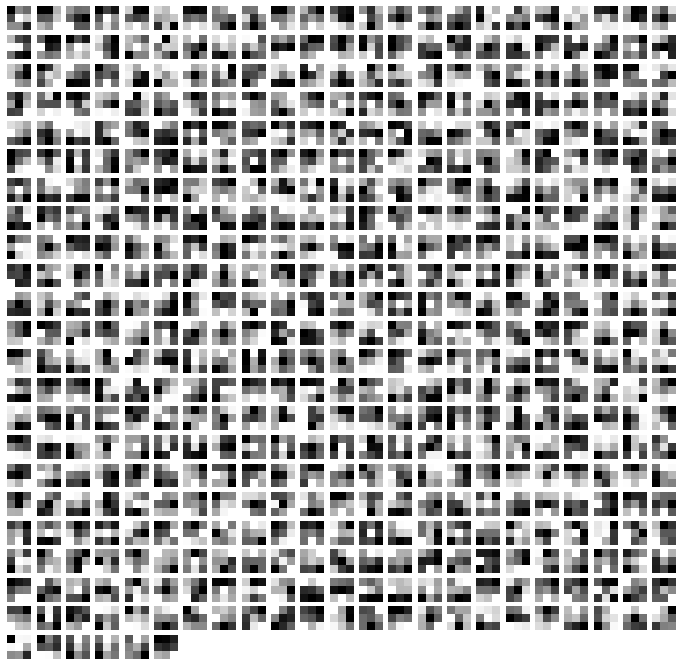

Filters of Conv Layer 12:


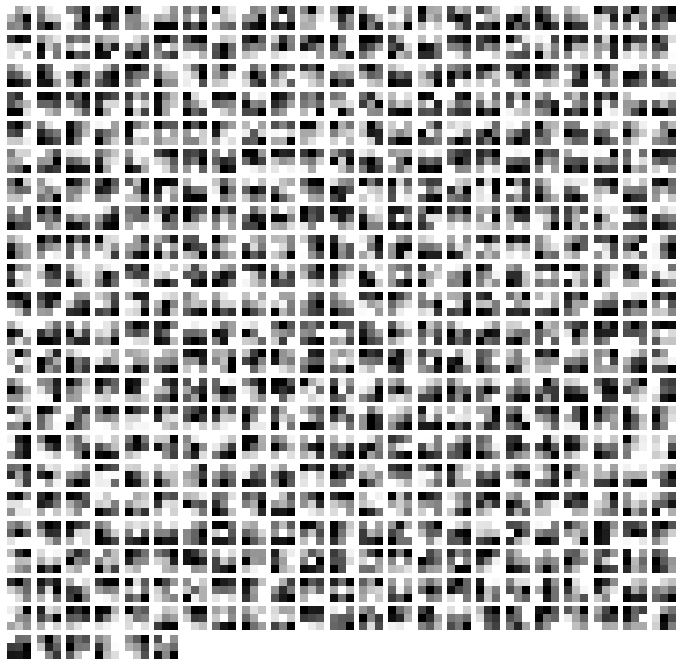

Filters of Conv Layer 13:


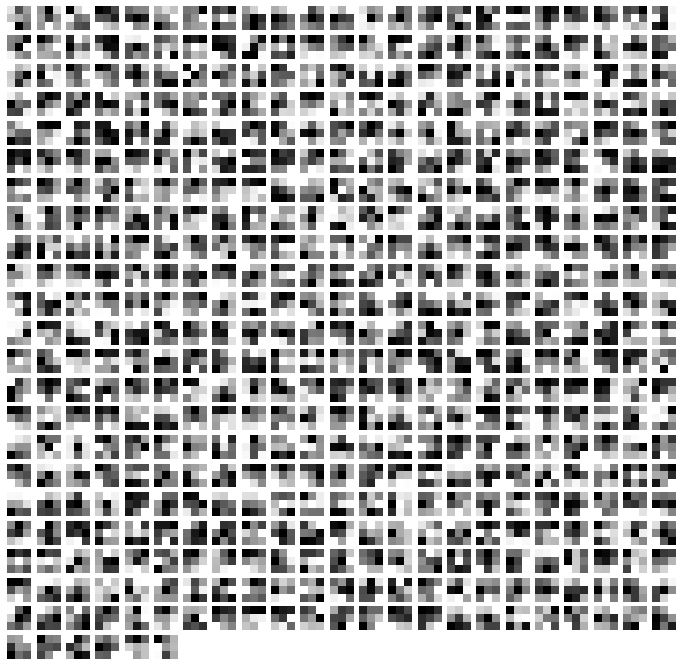

In [18]:
visualize_conv_filters(model, model_folder, str_dt)

## Activations

### EUROSatCNN

In [ ]:
class ActivationExtractorEuroSATCNN(nn.Module):
    def __init__(self, original_model, stop_layer):
        super(ActivationExtractorEuroSATCNN, self).__init__()
        self.stop_layer = stop_layer
        # Copy layers from the original model up to the flatten layer
        self.features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            original_model.relu1,
            original_model.conv2,
            original_model.bn2,
            original_model.relu2,
            original_model.pool1,
            original_model.dropout1,
            original_model.conv3,
            original_model.bn3,
            original_model.relu3,
            original_model.conv4,
            original_model.bn4,
            original_model.relu4,
            original_model.pool2,
            original_model.dropout2,
            original_model.conv5,
            original_model.bn5,
            original_model.relu5,
            original_model.conv6,
            original_model.bn6,
            original_model.relu6,
            original_model.pool3,
            original_model.dropout3,
            original_model.flatten,
            original_model.fc1
        )
        if stop_layer == 'fc1':
            self.classifier = nn.Identity()
        elif stop_layer == 'fc2':
            self.classifier = nn.Sequential(
                original_model.relu7,
                original_model.dropout4,
                original_model.fc2
            )
        

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
# Initialize the extractor model
# Create extractors for each fully connected layer
extractor_fc1 = ActivationExtractorEuroSATCNN(model, stop_layer='fc1')
extractor_fc2 = ActivationExtractorEuroSATCNN(model, stop_layer='fc2')
# Ensure the extractor model is on the same device as the inputs
extractor_fc1.to(device)
extractor_fc2.to(device)

extractor_fc1

In [ ]:
# Disable gradients computation
torch.set_grad_enabled(False);

In [ ]:
activations_fc1 = []
activations_fc2 = []
for data in test_loader:
    inputs, labels = data[0].to(device), data[1].to(device)
    activations_fc1.append(extractor_fc1(inputs).cpu().numpy())
    activations_fc2.append(extractor_fc2(inputs).cpu().numpy())

activations_fc1 = np.concatenate(activations_fc1)
activations_fc2 = np.concatenate(activations_fc2)

# Check the shape of the extracted features
print("Shape of extracted activations including dense layer 1:", activations_fc1.shape)
print("Shape of extracted activations including dense layer 2:", activations_fc2.shape)

#### Finding per unit top K samples

In [ ]:
# Load EUROSAT test dataset
testimages = datasets.ImageFolder(root=TEST_DIR, transform=None)

K = 10  # Number of top activations to retrieve
idxs_top10_fc1 = np.argsort(activations_fc1, axis=0)[::-1][0:K, :]
idxs_top10_fc2 = np.argsort(activations_fc2, axis=0)[::-1][0:K, :]

In [ ]:
# Initialize an array to store the picked samples
#picked_samples = np.zeros((K, n_units, 32, 32, 3), dtype=float)
picked_samples_fc1 = np.zeros((K, idxs_top10_fc1.shape[1], 64, 64, 3), dtype=float)
picked_samples_fc2 = np.zeros((K, idxs_top10_fc2.shape[1], 64, 64, 3), dtype=float)

for i in range(idxs_top10_fc1.shape[0]):
    for j in range(idxs_top10_fc1.shape[1]):
        # Normalize the images from CIFAR10 as they are PIL Images
        img_as_np = np.asarray(testimages[idxs_top10_fc1[i, j]][0]) / 255.0
        picked_samples_fc1[i, j, :, :, :] = img_as_np

for i in range(idxs_top10_fc2.shape[0]):
    for j in range(idxs_top10_fc2.shape[1]):
        # Normalize the images from CIFAR10 as they are PIL Images
        img_as_np = np.asarray(testimages[idxs_top10_fc2[i, j]][0]) / 255.0
        picked_samples_fc2[i, j, :, :, :] = img_as_np

# Check the shape of picked_samples
print("Shape of picked_samples including dense layer 1:", picked_samples_fc1.shape)
print("Shape of picked_samples including dense layer 2:", picked_samples_fc2.shape)
# The shape of the tensor corresponds to:
# (n_images,n_units,nb_rows,nb_cols,nb_channels)
# for each of the 2048 units in the layers, we have 10 images

##### Dense Layer 1

In [ ]:
units = np.rint(np.linspace(0, 127, num=20)).astype(int)
nunits = len(units)
# Slicing picked_samples to get the top K images for specified units
# Adjust the indexing to correctly slice the array
ims = picked_samples_fc1[:, units, :, :].squeeze()

filename = os.path.join(model_folder, f'topk_fc1_{str_dt}.png')
vis_topk(ims, units, filename)

##### Dense Layer 2

In [ ]:
units = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Specified units
nunits = len(units)
# Slicing picked_samples to get the top K images for specified units
# Adjust the indexing to correctly slice the array
ims = picked_samples_fc2[:, units, :, :].squeeze()

filename = os.path.join(model_folder, f'topk_fc2_{str_dt}.png')
vis_topk(ims, units, filename)

#### t-SNE plot on each of the Dense/Linear/Fully Connected layer.

##### Dense Layer 1

In [ ]:
# Perform PCA for dimensionality reduction before t-SNE
t0 = time.time()  # Start timer

# Perform t-SNE
n_components_tsne = 2  # t-SNE components (2D for visualization)
n_iter_tsne = 4000  # Number of iterations for t-SNE optimization
tsne = TSNE(n_components=n_components_tsne, random_state=0, n_iter=n_iter_tsne)


activations_fc1_tsne = tsne.fit_transform(activations_fc1)
t1 = time.time()  # Stop timer

print(f"t-SNE done! Time elapsed: {t1 - t0:.2f} seconds")
print("Shape of t-SNE 2D features:", activations_fc1_tsne.shape)

In [ ]:
# Retrieve the labels for test dataset
labels = [y for _, y in test_dataset]

In [ ]:
filename = os.path.join(model_folder, f't_SNE_fc1_{str_dt}.png')
plot_tsne(activations_fc1_tsne, labels, title="t-SNE visualization of ResNet50 activation, Dense Layer 1", filename=filename)

##### Dense Layer 2

In [ ]:
# Perform PCA for dimensionality reduction before t-SNE
t0 = time.time()  # Start timer

# Perform t-SNE
n_components_tsne = 2  # t-SNE components (2D for visualization)
n_iter_tsne = 4000  # Number of iterations for t-SNE optimization
tsne = TSNE(n_components=n_components_tsne, random_state=0, n_iter=n_iter_tsne)


activations_fc2_tsne = tsne.fit_transform(activations_fc2)
t1 = time.time()  # Stop timer

print(f"t-SNE done! Time elapsed: {t1 - t0:.2f} seconds")
print("Shape of t-SNE 2D features:", activations_fc2_tsne.shape)

In [ ]:
filename = os.path.join(model_folder, f't_SNE_fc2_{str_dt}.png')
plot_tsne(activations_fc1_tsne, labels, title="t-SNE visualization of ResNet50 activation, Output Layer", filename=filename)

### ResNet50 & ResNet152

In [ ]:
class ActivationExtractorResNet50_152(nn.Module):
    def __init__(self, original_model, layer_num=1):
        super(ActivationExtractorResNet50_152, self).__init__()

        self.features = nn.Sequential(*list(original_model.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        if layer_num == 1:
            self.fc = nn.Sequential(*list(original_model.fc.children())[:1])
        elif layer_num == 2:
            self.fc = nn.Sequential(*list(original_model.fc.children())[:4])

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# Initialize the extractor model
# Create extractors for each fully connected layer

# This command can be used for both 50 and 152.
extractor_fc1 = ActivationExtractorResNet50_152(model, 1)
extractor_fc2 = ActivationExtractorResNet50_152(model, 2)
extractor = model

# Disable gradients computation
torch.set_grad_enabled(False);

In [ ]:
extractor_fc1.to(device) # for fc1
extractor_fc2.to(device) # for fc2
extractor.to(device)

In [ ]:
activations_first_linear = []
activations_second_linear = []
activations_third_linear = []

for data in test_loader:
    inputs = data[0].to(device)
    
    # Extract and store the activations
    activations_first_linear.append(extractor_fc1(inputs).cpu().numpy())
    activations_second_linear.append(extractor_fc2(inputs).cpu().numpy())
    activations_third_linear.append(extractor(inputs).cpu().numpy())

# Concatenate the results from each extractor
activations_first_linear = np.concatenate(activations_first_linear)
activations_second_linear = np.concatenate(activations_second_linear)
activations_third_linear = np.concatenate(activations_third_linear)

# Check the shape of the extracted features
print("Shape of extracted activations including first linear layer:", activations_first_linear.shape)
print("Shape of extracted activations including second linear layer:", activations_second_linear.shape)
print("Shape of extracted activations including third linear layer:", activations_third_linear.shape)

#### Finding per unit top K samples

In [ ]:
# Load EUROSAT test dataset
testimages = datasets.ImageFolder(root=TEST_DIR, transform=None)

K = 10  # Number of top activations to retrieve

# For the first fully connected layer
idxs_top10_fc1 = np.argsort(activations_first_linear, axis=0)[::-1][0:K, :]

# For the second fully connected layer
idxs_top10_fc2 = np.argsort(activations_second_linear, axis=0)[::-1][0:K, :]

# For the final fully connected layer
idxs_top10_fc3 = np.argsort(activations_third_linear, axis=0)[::-1][0:K, :]

In [ ]:
idxs_top10_fc1.shape

In [ ]:
idxs_top10_fc2.shape

In [ ]:
idxs_top10_fc3.shape

In [ ]:
# Initialize arrays to store the picked samples
picked_samples_fc1 = np.zeros((K, idxs_top10_fc1.shape[1], 64, 64, 3), dtype=float)
picked_samples_fc2 = np.zeros((K, idxs_top10_fc2.shape[1], 64, 64, 3), dtype=float)
picked_samples_fc3 = np.zeros((K, idxs_top10_fc3.shape[1], 64, 64, 3), dtype=float)

for i in range(K):
    for j in range(idxs_top10_fc1.shape[1]):
        # Normalize the images from CIFAR10 as they are PIL Images
        img_as_np = np.asarray(testimages[idxs_top10_fc1[i, j]][0]) / 255.0
        picked_samples_fc1[i, j, :, :, :] = img_as_np

for i in range(K):
    for j in range(idxs_top10_fc2.shape[1]):
        # Normalize the images from CIFAR10 as they are PIL Images
        img_as_np = np.asarray(testimages[idxs_top10_fc2[i, j]][0]) / 255.0
        picked_samples_fc2[i, j, :, :, :] = img_as_np

for i in range(K):
    for j in range(idxs_top10_fc3.shape[1]):
        # Normalize the images from CIFAR10 as they are PIL Images
        img_as_np = np.asarray(testimages[idxs_top10_fc3[i, j]][0]) / 255.0
        picked_samples_fc3[i, j, :, :, :] = img_as_np

# Check the shape of picked_samples
print("Shape of picked_samples including dense layer 1:", picked_samples_fc1.shape)
print("Shape of picked_samples including dense layer 2:", picked_samples_fc2.shape)
print("Shape of picked_samples including dense layer 3:", picked_samples_fc3.shape)

##### Dense Layer 1

In [ ]:
units = np.rint(np.linspace(0, 1023, num=20)).astype(int)
nunits = len(units)
# Slicing picked_samples to get the top K images for specified units
# Adjust the indexing to correctly slice the array
ims = picked_samples_fc1[:, units, :, :].squeeze()
filename = os.path.join(model_folder, f'topk_fc1_{str_dt}.png')
vis_topk(ims, units, filename)

##### Dense Layer 2

In [ ]:
units = np.rint(np.linspace(0, 511, num=20)).astype(int)
nunits = len(units)
# Slicing picked_samples to get the top K images for specified units
# Adjust the indexing to correctly slice the array
ims = picked_samples_fc2[:, units, :, :].squeeze()
filename = os.path.join(model_folder, f'topk_fc2_{str_dt}.png')
vis_topk(ims, units, filename)

##### Dense Layer 3

In [ ]:
units = np.rint(np.linspace(0, 9, num=10)).astype(int)
nunits = len(units)
# Slicing picked_samples to get the top K images for specified units
# Adjust the indexing to correctly slice the array
ims = picked_samples_fc3[:, units, :, :].squeeze()
filename = os.path.join(model_folder, f'topk_fc3_{str_dt}.png')
vis_topk(ims, units, filename)

#### t-SNE plot on each of the Dense/Linear/Fully Connected layer.

##### Dense Layer 1

In [ ]:
# Perform PCA for dimensionality reduction before t-SNE
t0 = time.time()  # Start timer

# Perform t-SNE
n_components_tsne = 2  # t-SNE components (2D for visualization)
n_iter_tsne = 3000  # Number of iterations for t-SNE optimization
tsne = TSNE(n_components=n_components_tsne, random_state=0, n_iter=n_iter_tsne)


activations_fc1_tsne = tsne.fit_transform(activations_first_linear)
t1 = time.time()  # Stop timer

print(f"t-SNE done! Time elapsed: {t1 - t0:.2f} seconds")
print("Shape of t-SNE 2D features:", activations_fc1_tsne.shape)

In [ ]:
# Retrieve the labels for test dataset
labels = [y for _, y in test_dataset]

In [ ]:
filename = os.path.join(model_folder, f't_SNE_fc1_{str_dt}.png')
# plot_tsne(activations_fc1_tsne, labels, title="t-SNE visualization of ResNet50 activation, Dense Layer 1", filename=filename)
plot_tsne(activations_fc1_tsne, labels, title="t-SNE visualization of ResNet152 activation, Dense Layer 1", filename=filename)

##### Dense Layer 2

In [ ]:
# Perform PCA for dimensionality reduction before t-SNE
t0 = time.time()  # Start timer

# Perform t-SNE
n_components_tsne = 2  # t-SNE components (2D for visualization)
n_iter_tsne = 3000  # Number of iterations for t-SNE optimization
tsne = TSNE(n_components=n_components_tsne, random_state=0, n_iter=n_iter_tsne)


activations_fc2_tsne = tsne.fit_transform(activations_second_linear)
t1 = time.time()  # Stop timer

print(f"t-SNE done! Time elapsed: {t1 - t0:.2f} seconds")
print("Shape of t-SNE 2D features:", activations_fc2_tsne.shape)

In [ ]:
filename = os.path.join(model_folder, f't_SNE_fc2_{str_dt}.png')
# plot_tsne(activations_fc1_tsne, labels, title="t-SNE visualization of ResNet50 activation, Dense Layer 2", filename=filename)
plot_tsne(activations_fc1_tsne, labels, title="t-SNE visualization of ResNet152 activation, Dense Layer 2", filename=filename)

##### Dense Layer 3

In [ ]:
# Perform PCA for dimensionality reduction before t-SNE
t0 = time.time()  # Start timer

# Perform t-SNE
n_components_tsne = 2  # t-SNE components (2D for visualization)
n_iter_tsne = 3000  # Number of iterations for t-SNE optimization
tsne = TSNE(n_components=n_components_tsne, random_state=0, n_iter=n_iter_tsne)


activations_fc3_tsne = tsne.fit_transform(activations_third_linear)
t1 = time.time()  # Stop timer

print(f"t-SNE done! Time elapsed: {t1 - t0:.2f} seconds")
print("Shape of t-SNE 2D features:", activations_fc3_tsne.shape)

In [ ]:
filename = os.path.join(model_folder, f't_SNE_fc3_{str_dt}.png')
# plot_tsne(activations_fc3_tsne, labels, title="t-SNE visualization of ResNet50 activation, Output Layer", filename=filename)
plot_tsne(activations_fc3_tsne, labels, title="t-SNE visualization of ResNet152 activation, Output Layer", filename=filename)

### VGG16 & VGG19

In [8]:
class ActivationExtractorVGG(nn.Module):
    def __init__(self, original_model, layer_num=1):
        super(ActivationExtractorVGG, self).__init__()

        self.features = original_model.features
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        if layer_num == 1:
            self.classifier = nn.Sequential(*list(original_model.classifier.children())[:1])
        elif layer_num == 2:
            self.classifier = nn.Sequential(*list(original_model.classifier.children())[:4])

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
# Initialize the extractor model
# Create extractors for each fully connected layer

# This command can be used for both 50 and 152.
extractor_fc1 = ActivationExtractorVGG(model, 1)
# extractor_fc2 = ActivationExtractorVGG(model, 2)
# extractor = model

# Disable gradients computation
torch.set_grad_enabled(False);

In [10]:
extractor_fc1.to(device) # for fc1
# extractor_fc2.to(device) # for fc2
# extractor.to(device)

ActivationExtractorVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pa

In [11]:
activations_first_linear = []
# activations_second_linear = []
# activations_third_linear = []

for data in test_loader:
    inputs = data[0].to(device)
    
    # Extract and store the activations
    activations_first_linear.append(extractor_fc1(inputs).cpu().numpy())
    # activations_second_linear.append(extractor_fc2(inputs).cpu().numpy())
    # activations_third_linear.append(extractor(inputs).cpu().numpy())

# Concatenate the results from each extractor
activations_first_linear = np.concatenate(activations_first_linear)
# activations_second_linear = np.concatenate(activations_second_linear)
# activations_third_linear = np.concatenate(activations_third_linear)

# Check the shape of the extracted features
print("Shape of extracted activations including first linear layer:", activations_first_linear.shape)
# print("Shape of extracted activations including second linear layer:", activations_second_linear.shape)
# print("Shape of extracted activations including third linear layer:", activations_third_linear.shape)

Shape of extracted activations including first linear layer: (4050, 2048)


#### Finding per unit top K samples

In [ ]:
# Load EUROSAT test dataset
testimages = datasets.ImageFolder(root=TEST_DIR, transform=None)

K = 10  # Number of top activations to retrieve

# For the first fully connected layer
idxs_top10_fc1 = np.argsort(activations_first_linear, axis=0)[::-1][0:K, :]

# For the second fully connected layer
# idxs_top10_fc2 = np.argsort(activations_second_linear, axis=0)[::-1][0:K, :]

# For the final fully connected layer
# idxs_top10_fc3 = np.argsort(activations_third_linear, axis=0)[::-1][0:K, :]

In [ ]:
idxs_top10_fc1.shape

In [ ]:
idxs_top10_fc2.shape

In [ ]:
idxs_top10_fc3.shape

In [ ]:
# Initialize arrays to store the picked samples
picked_samples_fc1 = np.zeros((K, idxs_top10_fc1.shape[1], 64, 64, 3), dtype=float)
# picked_samples_fc2 = np.zeros((K, idxs_top10_fc2.shape[1], 64, 64, 3), dtype=float)
# picked_samples_fc3 = np.zeros((K, idxs_top10_fc3.shape[1], 64, 64, 3), dtype=float)

for i in range(K):
    for j in range(idxs_top10_fc1.shape[1]):
        # Normalize the images from CIFAR10 as they are PIL Images
        img_as_np = np.asarray(testimages[idxs_top10_fc1[i, j]][0]) / 255.0
        picked_samples_fc1[i, j, :, :, :] = img_as_np

# for i in range(K):
#     for j in range(idxs_top10_fc2.shape[1]):
#         # Normalize the images from CIFAR10 as they are PIL Images
#         img_as_np = np.asarray(testimages[idxs_top10_fc2[i, j]][0]) / 255.0
#         picked_samples_fc2[i, j, :, :, :] = img_as_np

# for i in range(K):
#     for j in range(idxs_top10_fc3.shape[1]):
#         # Normalize the images from CIFAR10 as they are PIL Images
#         img_as_np = np.asarray(testimages[idxs_top10_fc3[i, j]][0]) / 255.0
#         picked_samples_fc3[i, j, :, :, :] = img_as_np

# Check the shape of picked_samples
print("Shape of picked_samples including dense layer 1:", picked_samples_fc1.shape)
# print("Shape of picked_samples including dense layer 2:", picked_samples_fc2.shape)
# print("Shape of picked_samples including dense layer 3:", picked_samples_fc3.shape)

##### Dense Layer 1

In [ ]:
units = np.rint(np.linspace(0, 2047, num=20)).astype(int)
nunits = len(units)
# Slicing picked_samples to get the top K images for specified units
# Adjust the indexing to correctly slice the array
ims = picked_samples_fc1[:, units, :, :].squeeze()
filename = os.path.join(model_folder, f'topk_fc1_{str_dt}.png')
vis_topk(ims, units, filename)

##### Dense Layer 2

In [ ]:
units = np.rint(np.linspace(0, 1023, num=20)).astype(int)
nunits = len(units)
# Slicing picked_samples to get the top K images for specified units
# Adjust the indexing to correctly slice the array
ims = picked_samples_fc2[:, units, :, :].squeeze()
filename = os.path.join(model_folder, f'topk_fc2_{str_dt}.png')
vis_topk(ims, units, filename)

##### Dense Layer 3

In [ ]:
units = np.rint(np.linspace(0, 9, num=10)).astype(int)
nunits = len(units)
# Slicing picked_samples to get the top K images for specified units
# Adjust the indexing to correctly slice the array
ims = picked_samples_fc3[:, units, :, :].squeeze()
filename = os.path.join(model_folder, f'topk_fc3_{str_dt}.png')
vis_topk(ims, units, filename)

#### t-SNE plot on each of the Dense/Linear/Fully Connected layer.

##### Dense Layer 1

In [12]:
# Perform PCA for dimensionality reduction before t-SNE
t0 = time.time()  # Start timer

# Perform t-SNE
n_components_tsne = 2  # t-SNE components (2D for visualization)
n_iter_tsne = 3000  # Number of iterations for t-SNE optimization
tsne = TSNE(n_components=n_components_tsne, random_state=0, n_iter=n_iter_tsne)


activations_fc1_tsne = tsne.fit_transform(activations_first_linear)
t1 = time.time()  # Stop timer

print(f"t-SNE done! Time elapsed: {t1 - t0:.2f} seconds")
print("Shape of t-SNE 2D features:", activations_fc1_tsne.shape)

/home/odykypar/miniconda3/envs/aml-block3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/odykypar/miniconda3/envs/aml-block3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 19.87 seconds
Shape of t-SNE 2D features: (4050, 2)


In [13]:
# Retrieve the labels for test dataset
labels = [y for _, y in test_dataset]

/tmp/ipykernel_20884/1592976200.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scatter, ticks=range(num_classes))


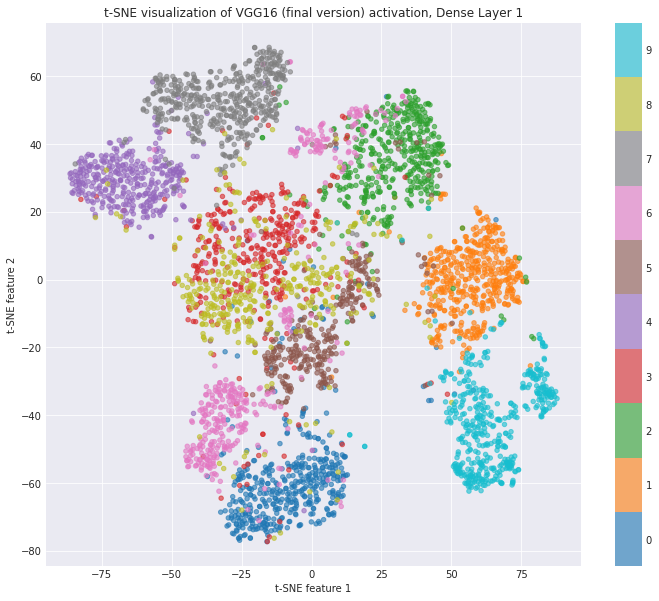

In [14]:
filename = os.path.join(model_folder, f't_SNE_fc1_{str_dt}.png')
plot_tsne(activations_fc1_tsne, labels, title="t-SNE visualization of VGG16 (final version) activation, Dense Layer 1", filename=filename)
# plot_tsne(activations_fc1_tsne, labels, title="t-SNE visualization of VGG19 activation, Dense Layer 1", filename=filename)

##### Dense Layer 2

In [ ]:
# Perform PCA for dimensionality reduction before t-SNE
t0 = time.time()  # Start timer

# Perform t-SNE
n_components_tsne = 2  # t-SNE components (2D for visualization)
n_iter_tsne = 3000  # Number of iterations for t-SNE optimization
tsne = TSNE(n_components=n_components_tsne, random_state=0, n_iter=n_iter_tsne)


activations_fc2_tsne = tsne.fit_transform(activations_second_linear)
t1 = time.time()  # Stop timer

print(f"t-SNE done! Time elapsed: {t1 - t0:.2f} seconds")
print("Shape of t-SNE 2D features:", activations_fc2_tsne.shape)

In [ ]:
filename = os.path.join(model_folder, f't_SNE_fc2_{str_dt}.png')
plot_tsne(activations_fc2_tsne, labels, title="t-SNE visualization of VGG16 (final version) activation, Dense Layer 2", filename=filename)
# plot_tsne(activations_fc2_tsne, labels, title="t-SNE visualization of VGG19 activation, Dense Layer 2", filename=filename)

##### Dense Layer 3

In [ ]:
# Perform PCA for dimensionality reduction before t-SNE
t0 = time.time()  # Start timer

# Perform t-SNE
n_components_tsne = 2  # t-SNE components (2D for visualization)
n_iter_tsne = 3000  # Number of iterations for t-SNE optimization
tsne = TSNE(n_components=n_components_tsne, random_state=0, n_iter=n_iter_tsne)


activations_fc3_tsne = tsne.fit_transform(activations_third_linear)
t1 = time.time()  # Stop timer

print(f"t-SNE done! Time elapsed: {t1 - t0:.2f} seconds")
print("Shape of t-SNE 2D features:", activations_fc3_tsne.shape)

In [ ]:
filename = os.path.join(model_folder, f't_SNE_fc3_{str_dt}.png')
plot_tsne(activations_fc3_tsne, labels, title="t-SNE visualization of VGG16 (final version) activation, Output Layer", filename=filename)
# plot_tsne(activations_fc3_tsne, labels, title="t-SNE visualization of VGG19 activation, Output Layer", filename=filename)